In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import joblib
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
else:
    print("Using CPU")

GPU Available:  []
Using CPU


In [3]:
class WADIAnomalyDetector:
    def __init__(self, data_path=None, df=None):
        """
        Initialize the WADI Anomaly Detector
        
        Args:
            data_path: Path to CSV file
            df: DataFrame if already loaded
        """
        if df is not None:
            self.df = df.copy()
        elif data_path:
            self.df = pd.read_csv(data_path)
        else:
            raise ValueError("Either data_path or df must be provided")
        
        self.models = {}
        self.scalers = {}
        self.results = {}
        self.predictions = {}
        
    def preprocess_data(self, test_size=0.3):
        """Preprocess the WADI dataset"""
        print("Preprocessing data...")

        self.df.columns = self.df.columns.str.strip()
        
        # Convert timestamp columns
        if 'Timestamp' in self.df.columns:
            self.df['Timestamp'] = pd.to_datetime(self.df['Timestamp'])
        if 'Date' in self.df.columns and 'Time' in self.df.columns:
            self.df['DateTime'] = pd.to_datetime(self.df['Date'] + ' ' + self.df['Time'])
        
        # Extract target variable
        target_col = 'Attack LABLE (1:No Attack, -1:Attack)'
        if target_col in self.df.columns:
            # Convert to binary (0: Normal, 1: Attack)
            self.y = (self.df[target_col] == -1).astype(int)
        else:
            raise ValueError(f"Target column '{target_col}' not found")
        
        # Select feature columns (exclude non-numeric and target columns)
        exclude_cols = ['Timestamp', 'Day', 'Row', 'Date', 'Time', 'DateTime', 
                       target_col, 'PLANT_START_STOP_LOG']
        
        feature_cols = [col for col in self.df.columns if col not in exclude_cols]
        self.X = self.df[feature_cols].copy()
        
        # Handle missing values
        self.X = self.X.fillna(self.X.median())
        
        # Convert boolean/status columns to numeric
        for col in self.X.columns:
            if self.X[col].dtype == 'object':
                self.X[col] = pd.to_numeric(self.X[col], errors='coerce')
        
        self.X = self.X.fillna(0)
        
        print(f"Dataset shape: {self.X.shape}")
        print(f"Attack ratio: {self.y.mean():.4f}")
        
        # Split data
        split_idx = int(len(self.X) * (1 - test_size))
        self.X_train, self.X_test = self.X[:split_idx], self.X[split_idx:]
        self.y_train, self.y_test = self.y[:split_idx], self.y[split_idx:]
        
        # Standardize features
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        # MinMax scaling for neural networks
        self.minmax_scaler = MinMaxScaler()
        self.X_train_minmax = self.minmax_scaler.fit_transform(self.X_train)
        self.X_test_minmax = self.minmax_scaler.transform(self.X_test)
        
        return self.X_train_scaled, self.X_test_scaled, self.y_train, self.y_test
    
    def train_isolation_forest(self):
        """Train Isolation Forest with hyperparameter tuning"""
        print("\n=== Training Isolation Forest ===")
        
        # Hyperparameter tuning
        param_grid = {
            'contamination': [0.1, 0.15, 0.2, 0.25],
            'n_estimators': [100, 200, 300],
            'max_samples': ['auto', 0.8, 0.9]
        }
        
        best_score = -np.inf
        best_params = None
        
        for contamination in param_grid['contamination']:
            for n_estimators in param_grid['n_estimators']:
                for max_samples in param_grid['max_samples']:
                    iso_forest = IsolationForest(
                        contamination=contamination,
                        n_estimators=n_estimators,
                        max_samples=max_samples,
                        random_state=42,
                        n_jobs=-1
                    )
                    
                    iso_forest.fit(self.X_train_scaled)
                    scores = iso_forest.decision_function(self.X_train_scaled)
                    
                    # Use negative scores for anomaly detection
                    if np.mean(scores) > best_score:
                        best_score = np.mean(scores)
                        best_params = {
                            'contamination': contamination,
                            'n_estimators': n_estimators,
                            'max_samples': max_samples
                        }
        
        print(f"Best Isolation Forest params: {best_params}")
        
        # Train final model
        self.models['isolation_forest'] = IsolationForest(**best_params, random_state=42, n_jobs=-1)
        self.models['isolation_forest'].fit(self.X_train_scaled)
        
        # Predictions
        train_pred = self.models['isolation_forest'].predict(self.X_train_scaled)
        test_pred = self.models['isolation_forest'].predict(self.X_test_scaled)
        
        # Convert to binary (1: anomaly, 0: normal)
        self.predictions['isolation_forest'] = {
            'train': (train_pred == -1).astype(int),
            'test': (test_pred == -1).astype(int),
            'train_scores': -self.models['isolation_forest'].decision_function(self.X_train_scaled),
            'test_scores': -self.models['isolation_forest'].decision_function(self.X_test_scaled)
        }
        
        print("Isolation Forest training completed!")
    
    def train_autoencoder(self):
        """Train Autoencoder with hyperparameter tuning"""
        print("\n=== Training Autoencoder ===")
        
        input_dim = self.X_train_minmax.shape[1]
        
        # Hyperparameter options
        architectures = [
            [64, 32, 16, 8, 16, 32, 64],
            [128, 64, 32, 64, 128],
            [256, 128, 64, 32, 64, 128, 256]
        ]
        
        learning_rates = [0.001, 0.0001]
        batch_sizes = [32, 64, 128]
        
        best_loss = np.inf
        best_config = None
        
        for arch in architectures:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    # Build autoencoder
                    encoder_input = Input(shape=(input_dim,))
                    x = encoder_input
                    
                    # Encoder
                    for units in arch[:len(arch)//2]:
                        x = Dense(units, activation='relu')(x)
                        x = Dropout(0.2)(x)
                    
                    encoded = x
                    
                    # Decoder
                    for units in arch[len(arch)//2:]:
                        x = Dense(units, activation='relu')(x)
                        x = Dropout(0.2)(x)
                    
                    decoded = Dense(input_dim, activation='sigmoid')(x)
                    
                    autoencoder = Model(encoder_input, decoded)
                    autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mse')
                    
                    # Train with early stopping
                    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
                    
                    # Use only normal data for training
                    normal_indices = self.y_train == 0
                    X_normal = self.X_train_minmax[normal_indices]
                    
                    history = autoencoder.fit(
                        X_normal, X_normal,
                        epochs=5,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=[early_stop, reduce_lr],
                        verbose=0
                    )
                    
                    val_loss = min(history.history['val_loss'])
                    if val_loss < best_loss:
                        best_loss = val_loss
                        best_config = {
                            'architecture': arch,
                            'learning_rate': lr,
                            'batch_size': batch_size,
                            'model': autoencoder
                        }
        
        print(f"Best Autoencoder config: {best_config['architecture']}, LR: {best_config['learning_rate']}, Batch: {best_config['batch_size']}")
        
        self.models['autoencoder'] = best_config['model']
        
        # Calculate reconstruction errors
        train_pred = self.models['autoencoder'].predict(self.X_train_minmax, verbose=0)
        test_pred = self.models['autoencoder'].predict(self.X_test_minmax, verbose=0)
        
        train_mse = np.mean(np.square(self.X_train_minmax - train_pred), axis=1)
        test_mse = np.mean(np.square(self.X_test_minmax - test_pred), axis=1)
        
        # Determine threshold using training data
        threshold = np.percentile(train_mse, 95)
        
        self.predictions['autoencoder'] = {
            'train': (train_mse > threshold).astype(int),
            'test': (test_mse > threshold).astype(int),
            'train_scores': train_mse,
            'test_scores': test_mse,
            'threshold': threshold
        }
        
        print("Autoencoder training completed!")
    
    def create_sequences(self, X, seq_length=10):
        """Create sequences for LSTM+CNN"""
        sequences = []
        for i in range(len(X) - seq_length + 1):
            sequences.append(X[i:i+seq_length])
        return np.array(sequences)
    
    def train_lstm_cnn(self):
        """Train LSTM+CNN hybrid model"""
        print("\n=== Training LSTM+CNN Hybrid ===")
        
        seq_length = 10
        
        # Create sequences
        X_train_seq = self.create_sequences(self.X_train_minmax, seq_length)
        X_test_seq = self.create_sequences(self.X_test_minmax, seq_length)
        y_train_seq = self.y_train[seq_length-1:]
        y_test_seq = self.y_test[seq_length-1:]
        
        # Hyperparameter tuning
        configurations = [
            {'cnn_filters': 64, 'lstm_units': 50, 'dense_units': 32, 'lr': 0.001},
            {'cnn_filters': 32, 'lstm_units': 100, 'dense_units': 64, 'lr': 0.0001},
            {'cnn_filters': 128, 'lstm_units': 75, 'dense_units': 50, 'lr': 0.001}
        ]
        
        best_val_loss = np.inf
        best_model = None
        
        for config in configurations:
            # Build LSTM+CNN model
            model = Sequential([
                Conv1D(filters=config['cnn_filters'], kernel_size=3, activation='relu', 
                       input_shape=(seq_length, self.X_train_minmax.shape[1])),
                MaxPooling1D(pool_size=2),
                LSTM(config['lstm_units'], return_sequences=False, dropout=0.3),
                Dense(config['dense_units'], activation='relu'),
                Dropout(0.5),
                Dense(1, activation='sigmoid')
            ])
            
            model.compile(
                optimizer=Adam(learning_rate=config['lr']),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            # Train model
            early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)
            
            history = model.fit(
                X_train_seq, y_train_seq,
                epochs=10,
                batch_size=64,
                validation_split=0.2,
                callbacks=[early_stop, reduce_lr],
                verbose=0
            )
            
            val_loss = min(history.history['val_loss'])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_config = config
        
        print(f"Best LSTM+CNN config: {best_config}")
        
        self.models['lstm_cnn'] = best_model
        
        # Predictions
        train_prob = self.models['lstm_cnn'].predict(X_train_seq, verbose=0).flatten()
        test_prob = self.models['lstm_cnn'].predict(X_test_seq, verbose=0).flatten()
        
        self.predictions['lstm_cnn'] = {
            'train': (train_prob > 0.5).astype(int),
            'test': (test_prob > 0.5).astype(int),
            'train_scores': train_prob,
            'test_scores': test_prob,
            'y_train_seq': y_train_seq,
            'y_test_seq': y_test_seq
        }
        
        print("LSTM+CNN training completed!")
    
    def train_ensemble_model(self):
        """Train ensemble model combining all three models"""
        print("\n=== Training Ensemble Model ===")
        
        # Get predictions from all models
        iso_scores = self.predictions['isolation_forest']['test_scores']
        ae_scores = self.predictions['autoencoder']['test_scores']
        lstm_scores = self.predictions['lstm_cnn']['test_scores']
        
        # Normalize scores to [0, 1]
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        
        iso_norm = scaler.fit_transform(iso_scores.reshape(-1, 1)).flatten()
        ae_norm = scaler.fit_transform(ae_scores.reshape(-1, 1)).flatten()
        
        # Adjust for LSTM+CNN sequence length
        min_len = min(len(iso_norm), len(ae_norm), len(lstm_scores))
        iso_norm = iso_norm[-min_len:]
        ae_norm = ae_norm[-min_len:]
        lstm_norm = lstm_scores[-min_len:]
        
        # Ensemble methods
        ensemble_methods = {
            'average': (iso_norm + ae_norm + lstm_norm) / 3,
            'weighted': 0.3 * iso_norm + 0.3 * ae_norm + 0.4 * lstm_norm,
            'max': np.maximum(np.maximum(iso_norm, ae_norm), lstm_norm)
        }
        
        best_method = None
        best_auc = 0
        
        y_test_adj = self.y_test[-min_len:]
        
        for method_name, scores in ensemble_methods.items():
            try:
                auc = roc_auc_score(y_test_adj, scores)
                if auc > best_auc:
                    best_auc = auc
                    best_method = method_name
            except:
                continue
        
        print(f"Best ensemble method: {best_method} (AUC: {best_auc:.4f})")
        
        self.predictions['ensemble'] = {
            'test': (ensemble_methods[best_method] > 0.5).astype(int),
            'test_scores': ensemble_methods[best_method],
            'y_test_adj': y_test_adj,
            'method': best_method
        }
        
        print("Ensemble training completed!")
    
    def evaluate_models(self):
        """Evaluate all models and generate results"""
        print("\n=== Model Evaluation ===")
        
        self.results = {}
        
        # Isolation Forest
        try:
            auc_if = roc_auc_score(self.y_test, self.predictions['isolation_forest']['test_scores'])
            precision_if = average_precision_score(self.y_test, self.predictions['isolation_forest']['test_scores'])
            
            self.results['Isolation Forest'] = {
                'AUC': auc_if,
                'Average Precision': precision_if,
                'Classification Report': classification_report(
                    self.y_test, self.predictions['isolation_forest']['test'], output_dict=True
                )
            }
        except Exception as e:
            print(f"Error evaluating Isolation Forest: {e}")
        
        # Autoencoder
        try:
            auc_ae = roc_auc_score(self.y_test, self.predictions['autoencoder']['test_scores'])
            precision_ae = average_precision_score(self.y_test, self.predictions['autoencoder']['test_scores'])
            
            self.results['Autoencoder'] = {
                'AUC': auc_ae,
                'Average Precision': precision_ae,
                'Classification Report': classification_report(
                    self.y_test, self.predictions['autoencoder']['test'], output_dict=True
                )
            }
        except Exception as e:
            print(f"Error evaluating Autoencoder: {e}")
        
        # LSTM+CNN
        try:
            y_test_seq = self.predictions['lstm_cnn']['y_test_seq']
            auc_lstm = roc_auc_score(y_test_seq, self.predictions['lstm_cnn']['test_scores'])
            precision_lstm = average_precision_score(y_test_seq, self.predictions['lstm_cnn']['test_scores'])
            
            self.results['LSTM+CNN'] = {
                'AUC': auc_lstm,
                'Average Precision': precision_lstm,
                'Classification Report': classification_report(
                    y_test_seq, self.predictions['lstm_cnn']['test'], output_dict=True
                )
            }
        except Exception as e:
            print(f"Error evaluating LSTM+CNN: {e}")
        
        # Ensemble
        try:
            y_test_adj = self.predictions['ensemble']['y_test_adj']
            auc_ensemble = roc_auc_score(y_test_adj, self.predictions['ensemble']['test_scores'])
            precision_ensemble = average_precision_score(y_test_adj, self.predictions['ensemble']['test_scores'])
            
            self.results['Ensemble'] = {
                'AUC': auc_ensemble,
                'Average Precision': precision_ensemble,
                'Classification Report': classification_report(
                    y_test_adj, self.predictions['ensemble']['test'], output_dict=True
                )
            }
        except Exception as e:
            print(f"Error evaluating Ensemble: {e}")
        
        # Print results
        print("\n" + "="*60)
        print("MODEL PERFORMANCE COMPARISON")
        print("="*60)
        
        for model_name, metrics in self.results.items():
            print(f"\n{model_name}:")
            print(f"  AUC-ROC: {metrics['AUC']:.4f}")
            print(f"  Average Precision: {metrics['Average Precision']:.4f}")
            if 'macro avg' in metrics['Classification Report']:
                print(f"  F1-Score: {metrics['Classification Report']['macro avg']['f1-score']:.4f}")
                print(f"  Precision: {metrics['Classification Report']['macro avg']['precision']:.4f}")
                print(f"  Recall: {metrics['Classification Report']['macro avg']['recall']:.4f}")
    
    def plot_results(self):
        """Create comprehensive visualizations"""
        print("\n=== Generating Visualizations ===")
        
        # Set up the plotting style
        plt.style.use('seaborn-v0_8')
        fig = plt.figure(figsize=(20, 15))
        
        # 1. ROC Curves
        plt.subplot(2, 3, 1)
        
        # Isolation Forest ROC
        try:
            fpr_if, tpr_if, _ = roc_curve(self.y_test, self.predictions['isolation_forest']['test_scores'])
            plt.plot(fpr_if, tpr_if, label=f'Isolation Forest (AUC = {self.results["Isolation Forest"]["AUC"]:.3f})')
        except:
            pass
        
        # Autoencoder ROC
        try:
            fpr_ae, tpr_ae, _ = roc_curve(self.y_test, self.predictions['autoencoder']['test_scores'])
            plt.plot(fpr_ae, tpr_ae, label=f'Autoencoder (AUC = {self.results["Autoencoder"]["AUC"]:.3f})')
        except:
            pass
        
        # LSTM+CNN ROC
        try:
            y_test_seq = self.predictions['lstm_cnn']['y_test_seq']
            fpr_lstm, tpr_lstm, _ = roc_curve(y_test_seq, self.predictions['lstm_cnn']['test_scores'])
            plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM+CNN (AUC = {self.results["LSTM+CNN"]["AUC"]:.3f})')
        except:
            pass
        
        # Ensemble ROC
        try:
            y_test_adj = self.predictions['ensemble']['y_test_adj']
            fpr_ens, tpr_ens, _ = roc_curve(y_test_adj, self.predictions['ensemble']['test_scores'])
            plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {self.results["Ensemble"]["AUC"]:.3f})', linewidth=2)
        except:
            pass
        
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Precision-Recall Curves
        plt.subplot(2, 3, 2)
        
        try:
            precision_if, recall_if, _ = precision_recall_curve(self.y_test, self.predictions['isolation_forest']['test_scores'])
            plt.plot(recall_if, precision_if, label=f'Isolation Forest (AP = {self.results["Isolation Forest"]["Average Precision"]:.3f})')
        except:
            pass
        
        try:
            precision_ae, recall_ae, _ = precision_recall_curve(self.y_test, self.predictions['autoencoder']['test_scores'])
            plt.plot(recall_ae, precision_ae, label=f'Autoencoder (AP = {self.results["Autoencoder"]["Average Precision"]:.3f})')
        except:
            pass
        
        try:
            precision_lstm, recall_lstm, _ = precision_recall_curve(y_test_seq, self.predictions['lstm_cnn']['test_scores'])
            plt.plot(recall_lstm, precision_lstm, label=f'LSTM+CNN (AP = {self.results["LSTM+CNN"]["Average Precision"]:.3f})')
        except:
            pass
        
        try:
            precision_ens, recall_ens, _ = precision_recall_curve(y_test_adj, self.predictions['ensemble']['test_scores'])
            plt.plot(recall_ens, precision_ens, label=f'Ensemble (AP = {self.results["Ensemble"]["Average Precision"]:.3f})', linewidth=2)
        except:
            pass
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Performance Comparison Bar Chart
        plt.subplot(2, 3, 3)
        models = list(self.results.keys())
        auc_scores = [self.results[model]['AUC'] for model in models]
        ap_scores = [self.results[model]['Average Precision'] for model in models]
        
        x = np.arange(len(models))
        width = 0.35
        
        plt.bar(x - width/2, auc_scores, width, label='AUC-ROC', alpha=0.8)
        plt.bar(x + width/2, ap_scores, width, label='Average Precision', alpha=0.8)
        
        plt.xlabel('Models')
        plt.ylabel('Score')
        plt.title('Performance Comparison')
        plt.xticks(x, models, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. Confusion Matrices
        for i, model_name in enumerate(['Isolation Forest', 'Autoencoder']):
            plt.subplot(2, 3, 4 + i)
            if model_name in self.results:
                if model_name == 'Isolation Forest':
                    cm = confusion_matrix(self.y_test, self.predictions['isolation_forest']['test'])
                else:
                    cm = confusion_matrix(self.y_test, self.predictions['autoencoder']['test'])
                
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f'{model_name} Confusion Matrix')
                plt.xlabel('Predicted')
                plt.ylabel('Actual')
        
        # 6. Anomaly Score Distributions
        plt.subplot(2, 3, 6)
        
        try:
            # Plot score distributions for each model
            plt.hist(self.predictions['isolation_forest']['test_scores'][self.y_test == 0], 
                    alpha=0.5, bins=50, label='IF Normal', density=True)
            plt.hist(self.predictions['isolation_forest']['test_scores'][self.y_test == 1], 
                    alpha=0.5, bins=50, label='IF Attack', density=True)
            
            plt.xlabel('Anomaly Score')
            plt.ylabel('Density')
            plt.title('Score Distributions')
            plt.legend()
            plt.grid(True, alpha=0.3)
        except:
            pass
        
        plt.tight_layout()
        plt.show()
        
        # Additional detailed results table
        self.create_results_table()
    
    def create_results_table(self):
        """Create a detailed results table"""
        print("\n" + "="*80)
        print("DETAILED RESULTS TABLE")
        print("="*80)
        
        results_df = []
        for model_name, metrics in self.results.items():
            row = {
                'Model': model_name,
                'AUC-ROC': f"{metrics['AUC']:.4f}",
                'Average Precision': f"{metrics['Average Precision']:.4f}"
            }
            
            if 'macro avg' in metrics['Classification Report']:
                row['Precision'] = f"{metrics['Classification Report']['macro avg']['precision']:.4f}"
                row['Recall'] = f"{metrics['Classification Report']['macro avg']['recall']:.4f}"
                row['F1-Score'] = f"{metrics['Classification Report']['macro avg']['f1-score']:.4f}"
            
            results_df.append(row)
        
        results_df = pd.DataFrame(results_df)
        print(results_df.to_string(index=False))
        
        return results_df
    
    def run_complete_analysis(self):
        """Run the complete anomaly detection analysis"""
        print("Starting WADI Anomaly Detection Analysis")
        print("="*50)
        
        # Preprocess data
        self.preprocess_data()
        
        # Train all models
        self.train_isolation_forest()
        self.train_autoencoder()
        self.train_lstm_cnn()
        self.train_ensemble_model()
        
        # Evaluate models
        self.evaluate_models()
        
        # Generate visualizations
        self.plot_results()
        
        print("\n" + "="*50)
        print("Analysis Complete!")
        print("="*50)
        
        return self.results, self.predictions
    
    def save_models_and_results(self, save_dir='wadi_models'):
        """Save all trained models, scalers, features, and results"""
        print(f"\n=== Saving Models and Results to {save_dir} ===")
        
        # Create save directory
        os.makedirs(save_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save feature columns used for training
        feature_info = {
            'feature_columns': list(self.X.columns),
            'n_features': len(self.X.columns),
            'timestamp': timestamp,
            'data_shape': self.X.shape
        }
        
        with open(f'{save_dir}/feature_info.json', 'w') as f:
            json.dump(feature_info, f, indent=2)
        
        # Save scalers
        joblib.dump(self.scaler, f'{save_dir}/standard_scaler.pkl')
        joblib.dump(self.minmax_scaler, f'{save_dir}/minmax_scaler.pkl')
        print("✓ Scalers saved")
        
        # Save Isolation Forest
        if 'isolation_forest' in self.models:
            joblib.dump(self.models['isolation_forest'], f'{save_dir}/isolation_forest_model.pkl')
            print("✓ Isolation Forest model saved")
        
        # Save Autoencoder
        if 'autoencoder' in self.models:
            self.models['autoencoder'].save(f'{save_dir}/autoencoder_model.h5')
            # Save autoencoder threshold
            ae_info = {
                'threshold': self.predictions['autoencoder']['threshold'],
                'timestamp': timestamp
            }
            with open(f'{save_dir}/autoencoder_info.json', 'w') as f:
                json.dump(ae_info, f, indent=2)
            print("✓ Autoencoder model saved")
        
        # Save LSTM+CNN
        if 'lstm_cnn' in self.models:
            self.models['lstm_cnn'].save(f'{save_dir}/lstm_cnn_model.h5')
            print("✓ LSTM+CNN model saved")
        
        # Save ensemble information
        if 'ensemble' in self.predictions:
            ensemble_info = {
                'method': self.predictions['ensemble']['method'],
                'timestamp': timestamp
            }
            with open(f'{save_dir}/ensemble_info.json', 'w') as f:
                json.dump(ensemble_info, f, indent=2)
            print("✓ Ensemble information saved")
        
        # Save results to CSV
        if hasattr(self, 'results') and self.results:
            results_data = []
            for model_name, metrics in self.results.items():
                row = {
                    'Model': model_name,
                    'AUC_ROC': metrics['AUC'],
                    'Average_Precision': metrics['Average Precision'],
                    'Timestamp': timestamp
                }
                
                if 'macro avg' in metrics['Classification Report']:
                    row['Precision'] = metrics['Classification Report']['macro avg']['precision']
                    row['Recall'] = metrics['Classification Report']['macro avg']['recall']
                    row['F1_Score'] = metrics['Classification Report']['macro avg']['f1-score']
                
                results_data.append(row)
            
            results_df = pd.DataFrame(results_data)
            results_df.to_csv(f'{save_dir}/model_results_{timestamp}.csv', index=False)
            print("✓ Results saved to CSV")
        
        # Save detailed results as JSON
        with open(f'{save_dir}/detailed_results_{timestamp}.json', 'w') as f:
            # Convert numpy types to regular Python types for JSON serialization
            json_results = {}
            for model_name, metrics in self.results.items():
                json_results[model_name] = {
                    'AUC': float(metrics['AUC']),
                    'Average_Precision': float(metrics['Average Precision']),
                    'Classification_Report': metrics['Classification Report']
                }
            json.dump(json_results, f, indent=2, default=str)
        print("✓ Detailed results saved to JSON")
        
        # Save model configuration
        config = {
            'timestamp': timestamp,
            'models_trained': list(self.models.keys()),
            'feature_count': len(self.X.columns),
            'training_data_shape': self.X.shape,
            'test_split_ratio': len(self.X_test) / len(self.X),
            'gpu_used': len(tf.config.list_physical_devices('GPU')) > 0
        }
        
        with open(f'{save_dir}/training_config_{timestamp}.json', 'w') as f:
            json.dump(config, f, indent=2)
        
        print(f"✓ All models and results saved in '{save_dir}' directory")
        print(f"  - Models: isolation_forest_model.pkl, autoencoder_model.h5, lstm_cnn_model.h5")
        print(f"  - Scalers: standard_scaler.pkl, minmax_scaler.pkl")
        print(f"  - Features: feature_info.json")
        print(f"  - Results: model_results_{timestamp}.csv, detailed_results_{timestamp}.json")
        
        return save_dir


class WADIPredictor:
    """Class for loading trained models and making predictions on new WADI data"""
    
    def __init__(self, model_dir='wadi_models'):
        """
        Initialize the predictor with saved models
        
        Args:
            model_dir: Directory containing saved models
        """
        self.model_dir = model_dir
        self.models = {}
        self.scalers = {}
        self.feature_info = None
        self.ae_threshold = None
        self.ensemble_method = None
        
    def load_models(self):
        """Load all saved models and scalers"""
        print(f"Loading models from {self.model_dir}...")
        
        try:
            # Load feature information
            with open(f'{self.model_dir}/feature_info.json', 'r') as f:
                self.feature_info = json.load(f)
            print("✓ Feature information loaded")
            
            # Load scalers
            self.scalers['standard'] = joblib.load(f'{self.model_dir}/standard_scaler.pkl')
            self.scalers['minmax'] = joblib.load(f'{self.model_dir}/minmax_scaler.pkl')
            print("✓ Scalers loaded")
            
            # Load Isolation Forest
            if os.path.exists(f'{self.model_dir}/isolation_forest_model.pkl'):
                self.models['isolation_forest'] = joblib.load(f'{self.model_dir}/isolation_forest_model.pkl')
                print("✓ Isolation Forest loaded")
            
            # Load Autoencoder
            if os.path.exists(f'{self.model_dir}/autoencoder_model.h5'):
                self.models['autoencoder'] = tf.keras.models.load_model(f'{self.model_dir}/autoencoder_model.h5')
                # Load threshold
                with open(f'{self.model_dir}/autoencoder_info.json', 'r') as f:
                    ae_info = json.load(f)
                    self.ae_threshold = ae_info['threshold']
                print("✓ Autoencoder loaded")
            
            # Load LSTM+CNN
            if os.path.exists(f'{self.model_dir}/lstm_cnn_model.h5'):
                self.models['lstm_cnn'] = tf.keras.models.load_model(f'{self.model_dir}/lstm_cnn_model.h5')
                print("✓ LSTM+CNN loaded")
            
            # Load ensemble info
            if os.path.exists(f'{self.model_dir}/ensemble_info.json'):
                with open(f'{self.model_dir}/ensemble_info.json', 'r') as f:
                    ensemble_info = json.load(f)
                    self.ensemble_method = ensemble_info['method']
                print("✓ Ensemble information loaded")
            
            print(f"Successfully loaded {len(self.models)} models")
            
        except Exception as e:
            print(f"Error loading models: {e}")
            raise
    
    def preprocess_test_data(self, df):
        """Preprocess test data using saved feature information and scalers"""
        print("Preprocessing test data...")
        
        # Extract the same features used during training
        feature_cols = self.feature_info['feature_columns']
        
        # Handle missing columns by filling with zeros
        for col in feature_cols:
            if col not in df.columns:
                df[col] = 0
                print(f"Warning: Missing column '{col}' filled with zeros")
        
        # Select only the features used during training
        X_test = df[feature_cols].copy()
        
        # Handle missing values
        X_test = X_test.fillna(X_test.median())
        
        # Convert to numeric
        for col in X_test.columns:
            if X_test[col].dtype == 'object':
                X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
        
        X_test = X_test.fillna(0)
        
        # Apply scaling
        X_test_scaled = self.scalers['standard'].transform(X_test)
        X_test_minmax = self.scalers['minmax'].transform(X_test)
        
        return X_test, X_test_scaled, X_test_minmax
    
    def create_sequences(self, X, seq_length=10):
        """Create sequences for LSTM+CNN prediction"""
        if len(X) < seq_length:
            # If data is shorter than sequence length, pad with zeros
            padding = np.zeros((seq_length - len(X), X.shape[1]))
            X_padded = np.vstack([padding, X])
            return X_padded.reshape(1, seq_length, X.shape[1])
        
        sequences = []
        for i in range(len(X) - seq_length + 1):
            sequences.append(X[i:i+seq_length])
        return np.array(sequences)
    
    def predict_single_model(self, model_name, X_scaled, X_minmax):
        """Make predictions using a single model"""
        predictions = {}
        
        if model_name == 'isolation_forest' and 'isolation_forest' in self.models:
            # Get anomaly scores (negative of decision function for consistency)
            scores = -self.models['isolation_forest'].decision_function(X_scaled)
            pred_binary = self.models['isolation_forest'].predict(X_scaled)
            pred_binary = (pred_binary == -1).astype(int)  # Convert to 0/1
            
            predictions = {
                'binary_predictions': pred_binary,
                'confidence_scores': scores,
                'model_type': 'isolation_forest'
            }
        
        elif model_name == 'autoencoder' and 'autoencoder' in self.models:
            # Get reconstruction errors
            reconstructed = self.models['autoencoder'].predict(X_minmax, verbose=0)
            mse_scores = np.mean(np.square(X_minmax - reconstructed), axis=1)
            pred_binary = (mse_scores > self.ae_threshold).astype(int)
            
            predictions = {
                'binary_predictions': pred_binary,
                'confidence_scores': mse_scores,
                'model_type': 'autoencoder'
            }
        
        elif model_name == 'lstm_cnn' and 'lstm_cnn' in self.models:
            # Create sequences and predict
            seq_length = 10
            X_sequences = self.create_sequences(X_minmax, seq_length)
            
            if len(X_sequences) > 0:
                prob_scores = self.models['lstm_cnn'].predict(X_sequences, verbose=0).flatten()
                pred_binary = (prob_scores > 0.5).astype(int)
                
                # For sequences, we need to handle the length difference
                # Pad the beginning with the first prediction
                if len(prob_scores) < len(X_scaled):
                    padding_length = len(X_scaled) - len(prob_scores)
                    prob_scores = np.concatenate([np.full(padding_length, prob_scores[0]), prob_scores])
                    pred_binary = np.concatenate([np.full(padding_length, pred_binary[0]), pred_binary])
                
                predictions = {
                    'binary_predictions': pred_binary,
                    'confidence_scores': prob_scores,
                    'model_type': 'lstm_cnn'
                }
            else:
                # Handle case where sequence creation fails
                predictions = {
                    'binary_predictions': np.zeros(len(X_scaled)),
                    'confidence_scores': np.zeros(len(X_scaled)),
                    'model_type': 'lstm_cnn'
                }
        
        return predictions
    
    def predict_ensemble(self, X_scaled, X_minmax):
        """Make ensemble predictions combining all models"""
        individual_predictions = {}
        
        # Get predictions from all available models
        for model_name in ['isolation_forest', 'autoencoder', 'lstm_cnn']:
            if model_name in self.models:
                individual_predictions[model_name] = self.predict_single_model(model_name, X_scaled, X_minmax)
        
        if len(individual_predictions) == 0:
            return None
        
        # Normalize scores and combine based on ensemble method
        normalized_scores = {}
        from sklearn.preprocessing import MinMaxScaler
        
        for model_name, pred_data in individual_predictions.items():
            scaler = MinMaxScaler()
            scores = pred_data['confidence_scores']
            normalized_scores[model_name] = scaler.fit_transform(scores.reshape(-1, 1)).flatten()
        
        # Combine scores based on the saved ensemble method
        if self.ensemble_method == 'average':
            ensemble_scores = np.mean(list(normalized_scores.values()), axis=0)
        elif self.ensemble_method == 'weighted':
            # Use the same weights as training (you might want to save these)
            weights = {'isolation_forest': 0.3, 'autoencoder': 0.3, 'lstm_cnn': 0.4}
            ensemble_scores = np.zeros(len(X_scaled))
            for model_name, scores in normalized_scores.items():
                if model_name in weights:
                    ensemble_scores += weights[model_name] * scores
        elif self.ensemble_method == 'max':
            ensemble_scores = np.maximum.reduce(list(normalized_scores.values()))
        else:
            # Default to average
            ensemble_scores = np.mean(list(normalized_scores.values()), axis=0)
        
        ensemble_binary = (ensemble_scores > 0.5).astype(int)
        
        return {
            'binary_predictions': ensemble_binary,
            'confidence_scores': ensemble_scores,
            'individual_predictions': individual_predictions,
            'model_type': 'ensemble'
        }
    
    def predict_on_dataset(self, csv_path, output_path=None):
        """
        Load dataset, make predictions, and save results with confidence scores
        
        Args:
            csv_path: Path to the test dataset
            output_path: Path to save results (optional)
        
        Returns:
            DataFrame with original data plus predictions and confidence scores
        """
        print(f"Loading test dataset from {csv_path}...")
        
        # Load the test dataset
        df = pd.read_csv(csv_path)
        print(f"Test dataset shape: {df.shape}")
        
        # Preprocess the data
        X_test, X_test_scaled, X_test_minmax = self.preprocess_test_data(df)
        
        # Make predictions with each model
        results_df = df.copy()
        
        print("Making predictions...")
        
        # Individual model predictions
        for model_name in ['isolation_forest', 'autoencoder', 'lstm_cnn']:
            if model_name in self.models:
                print(f"  Processing {model_name}...")
                pred_data = self.predict_single_model(model_name, X_test_scaled, X_test_minmax)
                
                results_df[f'{model_name}_prediction'] = pred_data['binary_predictions']
                results_df[f'{model_name}_confidence'] = pred_data['confidence_scores']
        
        # Ensemble predictions
        if len(self.models) > 1:
            print("  Processing ensemble...")
            ensemble_pred = self.predict_ensemble(X_test_scaled, X_test_minmax)
            if ensemble_pred:
                results_df['ensemble_prediction'] = ensemble_pred['binary_predictions']
                results_df['ensemble_confidence'] = ensemble_pred['confidence_scores']
        
        # Add summary columns
        results_df['prediction_timestamp'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        # Calculate consensus (majority vote from available models)
        pred_cols = [col for col in results_df.columns if col.endswith('_prediction')]
        if len(pred_cols) > 1:
            results_df['consensus_prediction'] = results_df[pred_cols].mode(axis=1)[0]
        
        print(f"Predictions completed!")
        print(f"Predicted {results_df[pred_cols].sum().sum()} total anomalies across all models")
        
        # Save results if output path provided
        if output_path:
            results_df.to_csv(output_path, index=False)
            print(f"Results saved to {output_path}")
        
        # Print summary statistics
        self.print_prediction_summary(results_df)
        
        return results_df
    
    def print_prediction_summary(self, results_df):
        """Print summary of predictions"""
        print("\n" + "="*60)
        print("PREDICTION SUMMARY")
        print("="*60)
        
        pred_cols = [col for col in results_df.columns if col.endswith('_prediction')]
        
        for col in pred_cols:
            model_name = col.replace('_prediction', '')
            anomaly_count = results_df[col].sum()
            anomaly_rate = anomaly_count / len(results_df) * 100
            
            print(f"{model_name.upper()}:")
            print(f"  Anomalies detected: {anomaly_count}/{len(results_df)} ({anomaly_rate:.2f}%)")
            
            # Get confidence stats for anomalies
            conf_col = col.replace('_prediction', '_confidence')
            if conf_col in results_df.columns:
                anomaly_confidences = results_df[results_df[col] == 1][conf_col]
                if len(anomaly_confidences) > 0:
                    print(f"  Average confidence for anomalies: {anomaly_confidences.mean():.4f}")
                    print(f"  Confidence range: {anomaly_confidences.min():.4f} - {anomaly_confidences.max():.4f}")
            print()

STEP 1: Training and Saving Models
Starting WADI Anomaly Detection Analysis
Preprocessing data...
Dataset shape: (172803, 126)
Attack ratio: 0.0577

=== Training Isolation Forest ===
Best Isolation Forest params: {'contamination': 0.1, 'n_estimators': 100, 'max_samples': 'auto'}
Isolation Forest training completed!

=== Training Autoencoder ===
Best Autoencoder config: [128, 64, 32, 64, 128], LR: 0.001, Batch: 32
Autoencoder training completed!

=== Training LSTM+CNN Hybrid ===
Best LSTM+CNN config: {'cnn_filters': 128, 'lstm_units': 75, 'dense_units': 50, 'lr': 0.001}
LSTM+CNN training completed!

=== Training Ensemble Model ===
Best ensemble method: weighted (AUC: 0.9056)
Ensemble training completed!

=== Model Evaluation ===

MODEL PERFORMANCE COMPARISON

Isolation Forest:
  AUC-ROC: 0.8886
  Average Precision: 0.2636
  F1-Score: 0.6202
  Precision: 0.6018
  Recall: 0.7987

Autoencoder:
  AUC-ROC: 0.8278
  Average Precision: 0.3710
  F1-Score: 0.4326
  Precision: 0.5476
  Recall: 0.

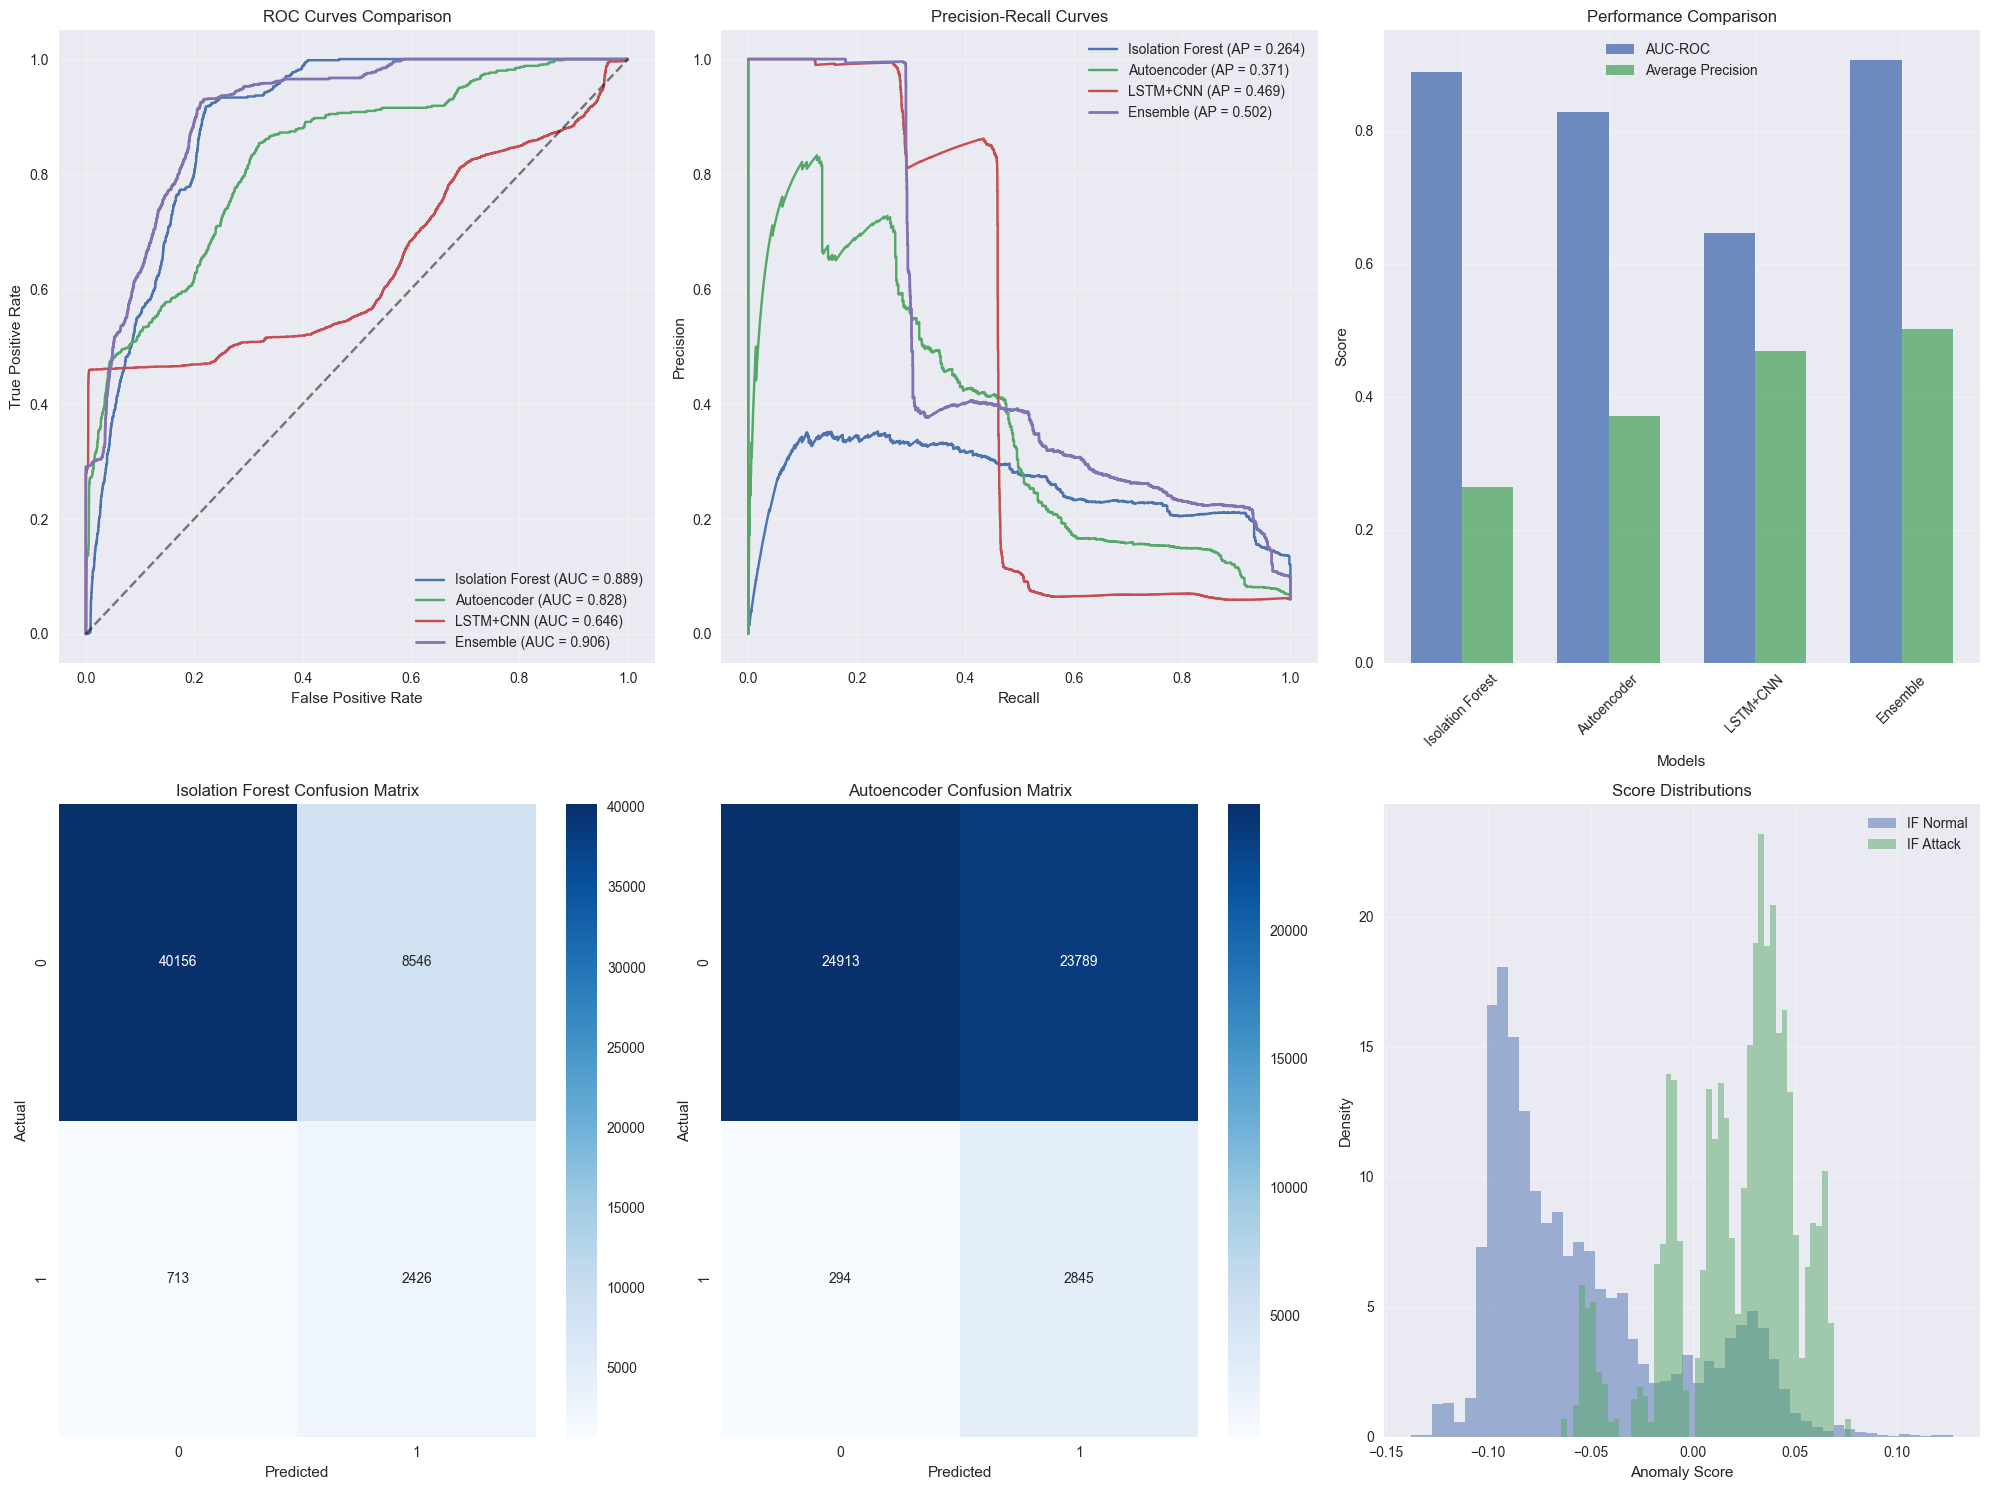


DETAILED RESULTS TABLE
           Model AUC-ROC Average Precision Precision Recall F1-Score
Isolation Forest  0.8886            0.2636    0.6018 0.7987   0.6202
     Autoencoder  0.8278            0.3710    0.5476 0.7089   0.4326
        LSTM+CNN  0.6459            0.4694    0.8856 0.6438   0.7026
        Ensemble  0.9056            0.5018    0.8782 0.6437   0.7017

Analysis Complete!

=== Saving Models and Results to wadi_models ===
✓ Scalers saved
✓ Isolation Forest model saved
✓ Autoencoder model saved
✓ LSTM+CNN model saved
✓ Ensemble information saved
✓ Results saved to CSV
✓ Detailed results saved to JSON
✓ All models and results saved in 'wadi_models' directory
  - Models: isolation_forest_model.pkl, autoencoder_model.h5, lstm_cnn_model.h5
  - Scalers: standard_scaler.pkl, minmax_scaler.pkl
  - Features: feature_info.json
  - Results: model_results_20250612_141252.csv, detailed_results_20250612_141252.json
Step 1 completed - models saved

STEP 2: Loading Models and Making Predi

In [4]:
# Usage Example for the new functionality:
def example_usage():
    """Example of how to use the enhanced WADI detector"""
    
    # Step 1: Train models and save them
    print("="*60)
    print("STEP 1: Training and Saving Models")
    print("="*60)
    
    # Load training data
    detector = WADIAnomalyDetector(data_path='WADI_attackdataLABLE.csv')
    results, predictions = detector.run_complete_analysis()
    save_dir = detector.save_models_and_results()
    
    print("Step 1 completed - models saved")
    
    # Step 2: Load models and predict on new data
    print("\n" + "="*60)
    print("STEP 2: Loading Models and Making Predictions")
    print("="*60)
    
    # Initialize predictor
    predictor = WADIPredictor(model_dir='wadi_models')
    predictor.load_models()
    
    # Make predictions on new dataset
    results_df = predictor.predict_on_dataset(
        csv_path='WADI_attackdataLABLE.csv',
        output_path='wadi_predictions_with_confidence.csv'
    )
    
    print("Step 2 completed - predictions saved")
    
    return results_df

# Usage Example:
if __name__ == "__main__":
    # Load your WADI dataset
    df = pd.read_csv('WADI_attackdataLABLE.csv')
    
    # Or if you have the dataframe already loaded:
    detector = WADIAnomalyDetector(df=df)
    
    # For demonstration, create a sample dataset with the expected structure
    '''print("Note: Please replace this section with your actual WADI dataset loading")
    print("\nExample usage for training:")
    print("detector = WADIAnomalyDetector(data_path='path_to_your_wadi_dataset.csv')")
    print("results, predictions = detector.run_complete_analysis()")
    print("save_dir = detector.save_models_and_results()")
    
    print("\nExample usage for prediction:")
    print("predictor = WADIPredictor(model_dir='wadi_models')")
    print("predictor.load_models()")
    print("results_df = predictor.predict_on_dataset('WADI_attackdataLABLE.csv', 'predictions_output.csv')")'''
    
    # Uncomment the following to run the actual example
    example_usage()